In [1]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from scipy.stats import kurtosis
import os
import copy
import time

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [2]:
data_path = '../data/Dataset' 
os.listdir(data_path)

['fixed_dataset(매출건수).csv',
 'fixed_dataset(자동차유지,10퍼센트절사평균).csv',
 'fixed_dataset(자동차제거,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv',
 'fixed_dataset(자동차제거,매출raw,null유지).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1126).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,버퍼점포밀도,1202).csv',
 'fixed_dataset.csv',
 'fixed_dataset_1105.csv',
 'fixed_dataset_1214.csv']

In [3]:
# 1. 매출 log, null 유지
data = pd.read_csv(os.path.join(data_path,'fixed_dataset_1214.csv'),encoding='euc-kr')

# 2. 자동차제거,매출log,null유지,절사평균
# data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv'),encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,1.609438,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.127535,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,2.029155,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.364045,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.289920,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               161 non-null    int64  
 1   BAS_AR               161 non-null    float64
 2   도로길이고려_전체통합도         161 non-null    float64
 3   도로길이고려_국부통합도_R3      161 non-null    float64
 4   기초구역평균_전체통합도         161 non-null    float64
 5   기초구역평균_국부통합도_R3      161 non-null    float64
 6   도로율                  161 non-null    float64
 7   평균 도로 길이             161 non-null    float64
 8   아파트시세변화_차분평균         161 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             160 non-null    float64
 12  평균최근접정류장거리           160 non-null    float64
 13  건물노후도                161 non-null    float64
 14  공동주택 비율              161 non-null    float64
 15  근린생활시설 비율            161 non-null    flo

## 1.1 결측치 확인

In [5]:
drop_list = [col for col in list(data) if '변화' in col]
drop_list += ['BAS_AR','건물노후도']
data = data.drop(drop_list,axis=1)

In [6]:
data.isnull().sum()

BAS_ID                  0
도로길이고려_전체통합도            0
도로길이고려_국부통합도_R3         0
기초구역평균_전체통합도            0
기초구역평균_국부통합도_R3         0
도로율                     0
평균 도로 길이                0
평균영업기간                  3
평균폐업기간                 10
평균최근접역거리                1
평균최근접정류장거리              1
공동주택 비율                 0
근린생활시설 비율               0
단독주택 비율                 0
아파트 가구수                 0
외식업매출비율                 8
서비스업매출비율                5
소매업매출비율                 5
외식업종다양성                 1
서비스업종다양성                1
소매업종다양성                 1
상가밀도                    1
주중 / 주말                 0
06 to 18 / 18 to 06     0
(주거인구+직장인구) / 유동인구      0
주거인구/직장인구               0
10_30 / 40_60           0
점포밀도                    1
dtype: int64

### 1.1.1 운영 평균 영업 개월, 폐업 평균 영업 개월
- 운영 평균 영업 개월 : 영업, 폐업 둘 다 없을 경우 제거
- 폐업 평균 영업 개월 : 영업, ㅍ영업기간은 있지만 폐업기간이 없을 경우 제거

In [7]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,2.666667
27,21327,89.858108,NaN,12.000000
39,21339,82.104355,NaN,0.000000
72,21372,NaN,NaN,28.500000
73,21373,252.747147,NaN,26.633333
75,21375,NaN,NaN,2.000000
81,21381,183.029083,NaN,16.920000
86,21386,132.306618,NaN,10.750000
159,21459,165.177930,NaN,2.666667
160,21460,NaN,NaN,NaN


In [8]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균폐업기간'].isnull()].index)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [9]:
clean_data.isnull().sum()

BAS_ID                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
공동주택 비율                0
근린생활시설 비율              0
단독주택 비율                0
아파트 가구수                0
외식업매출비율                1
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말                0
06 to 18 / 18 to 06    0
(주거인구+직장인구) / 유동인구     0
주거인구/직장인구              0
10_30 / 40_60          0
점포밀도                   0
dtype: int64

In [10]:
# 매출 비율 데이터가 없는 경우는 매출 데이터가 없는 경우이므로 0으로 치환
clean_data.fillna(0,inplace=True)

In [11]:
clean_data.isnull().sum()

BAS_ID                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
공동주택 비율                0
근린생활시설 비율              0
단독주택 비율                0
아파트 가구수                0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말                0
06 to 18 / 18 to 06    0
(주거인구+직장인구) / 유동인구     0
주거인구/직장인구              0
10_30 / 40_60          0
점포밀도                   0
dtype: int64

## 1.2 geometry 정보 로딩

In [12]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [13]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area.head()

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [15]:
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,평균영업기간,평균폐업기간,평균최근접역거리,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도,geometry
0,21300,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,163.106482,199.056791,1.172716,...,1.609438,2.390980,86.099041,2.342449,2.695669,0.268398,0.149563,0.406896,7.046875,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,156.249615,52.896363,1.696683,...,1.127535,1.985080,346.978396,2.315147,2.280277,0.254881,0.667946,0.439757,11.523810,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,111.950730,93.787005,1.697811,...,2.029155,1.314799,876.110071,2.064957,2.339853,0.220317,0.899425,0.508371,143.584416,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,153.728003,161.293272,1.802432,...,2.364045,2.064017,232.748015,2.273528,2.246297,0.108296,6.308614,0.441902,36.111111,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,177.329451,100.922903,1.604301,...,2.289920,2.379112,2495.942389,2.016228,2.004099,0.212989,1.959390,0.479893,113.836066,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [16]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:].head()

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319


## 1.3 기초통계량

In [17]:
basis_stat = clean_data.iloc[:,1:-3].describe().transpose().apply(lambda x : round(x,4))
basis_stat

,count,mean,std,min,25%,50%,75%,max
도로길이고려_전체통합도,151.0,350.4701,170.7041,78.9331,224.9908,305.5336,458.7519,938.4161
도로길이고려_국부통합도_R3,151.0,4160.3605,2018.7385,872.3422,2720.9754,3832.0170,5235.4772,11731.5519
기초구역평균_전체통합도,151.0,0.0944,0.0181,0.0532,0.0847,0.0953,0.1055,0.1795
기초구역평균_국부통합도_R3,151.0,1.0947,0.0816,0.8628,1.0562,1.0938,1.1441,1.3324
도로율,151.0,28.4688,12.7373,2.6729,20.0999,28.4181,36.2826,62.5353
평균 도로 길이,151.0,166.0892,81.5538,59.3114,113.6618,143.8354,199.1820,535.7467
평균영업기간,151.0,131.9480,29.5567,41.1814,117.7842,132.3305,149.5740,226.7587
평균폐업기간,151.0,107.6293,40.8445,19.8991,82.7522,101.9597,127.3640,244.4929
평균최근접역거리,151.0,0.7129,0.4924,0.1039,0.3256,0.5490,0.9220,1.9089
평균최근접정류장거리,151.0,0.0854,0.0412,0.0335,0.0610,0.0765,0.0965,0.3319


In [18]:
basis_stat.drop(['25%','50%','75%'],axis=1).to_csv('../data/전처리 파일/기초통계량.csv',encoding='euc-kr')

## 1.4 데이터 분포 확인

In [19]:
ind_var = clean_data.drop(['BAS_ID','geometry','x','y','평균영업기간','평균폐업기간'],axis=1)

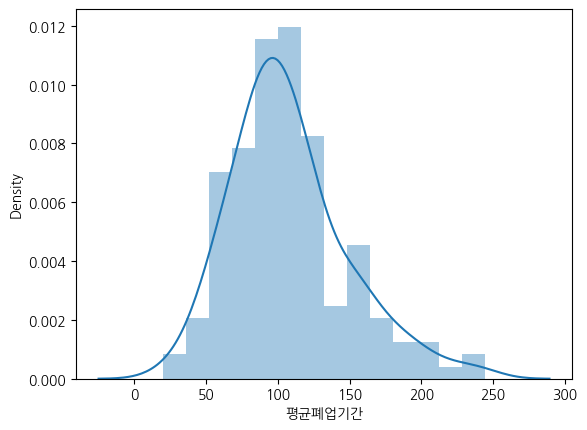

In [22]:
sns.distplot(clean_data['평균폐업기간'])
plt.show()

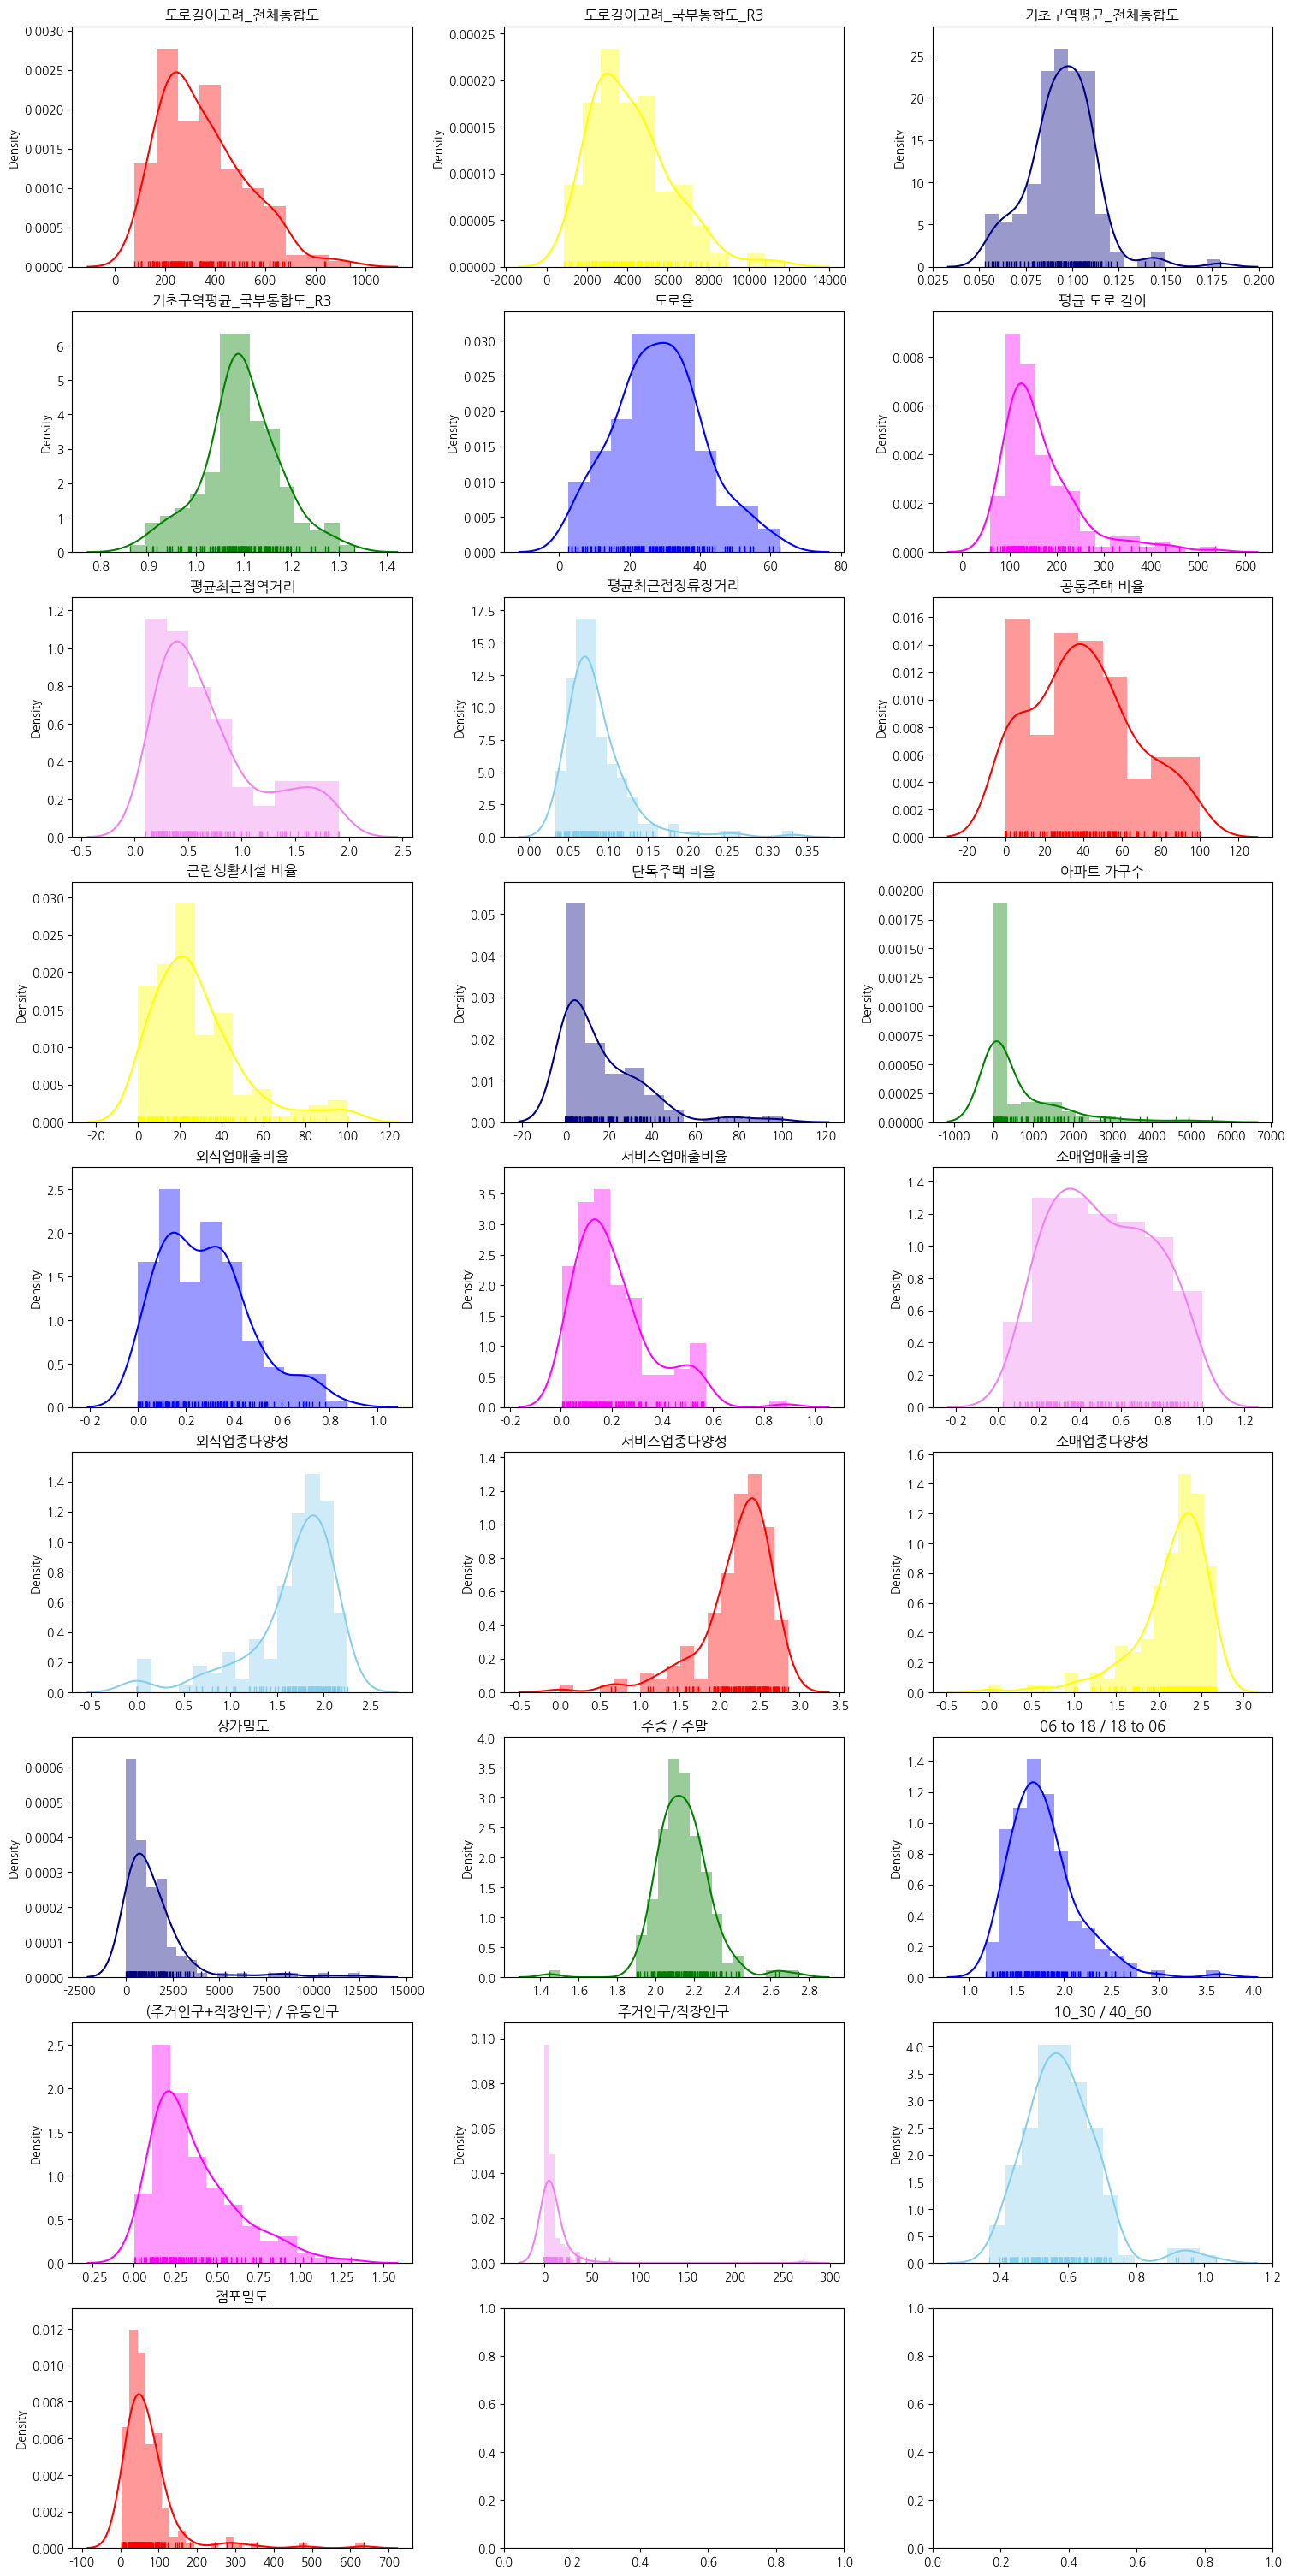

In [21]:
col_list = list(ind_var)
nrows = int(len(col_list)/3)+1
ncols = 3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,30),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(nrows):
    for j in range(ncols):
        if (ncols*i+j) == len(col_list):
            break
        
        sns.distplot(ax=axes[i,j], x=ind_var[col_list[(ncols*i+j)]], kde=True,color=color[(ncols*i+j) % len(color)],rug=True)
        axes[i,j].set_title(col_list[ncols*i+j])

plt.savefig('../data/결과 이미지/기초통계량 분포.jpg')
plt.show()

## 1.5 다중공선성 확인 및 제거

In [23]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(ind_var)
result.iloc[-5:,]

,VIF Factor,features
20,182.533485,도로길이고려_전체통합도
21,184.442184,기초구역평균_전체통합도
22,284.084301,소매업매출비율
23,447.895917,주중 / 주말
24,526.639174,기초구역평균_국부통합도_R3


In [24]:
def RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
#         display(result[-7:])
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(ind_var)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['주거인구/직장인구',
 '아파트 가구수',
 '단독주택 비율',
 '서비스업매출비율',
 '외식업매출비율',
 '근린생활시설 비율',
 '평균최근접역거리',
 '(주거인구+직장인구) / 유동인구',
 '공동주택 비율',
 '평균 도로 길이',
 '도로길이고려_전체통합도',
 '평균최근접정류장거리',
 '점포밀도',
 '도로율',
 '상가밀도']

# 2. 공간적 상관성 및 이질성 검증

## 2.1 Moran's I 검정
- H0 : 군집이 존재하지 않는다. 즉, 모든 구역이 Randomness를 가진다.(AutoCorrelation이 없다.)
- 유의 수준 : 0.05
- 검정통계량 : Morans'I

In [63]:
gdf = gpd.GeoDataFrame(clean_data.geometry)
y = clean_data['평균폐업기간'].values

w = Queen.from_dataframe(gdf)
moran = Moran(y, w)
moran.I

0.18560315065384791

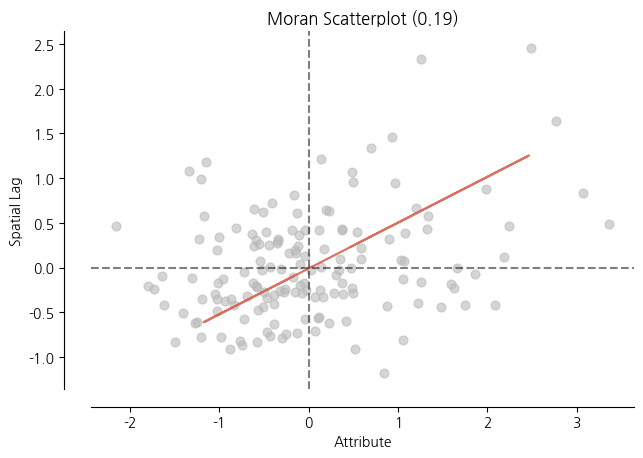

In [68]:
spatial_path = '../data/결과 이미지/공간적 상관성 및 이질성'

fig, ax = moran_scatterplot(moran, aspect_equal=True)

plt.show()

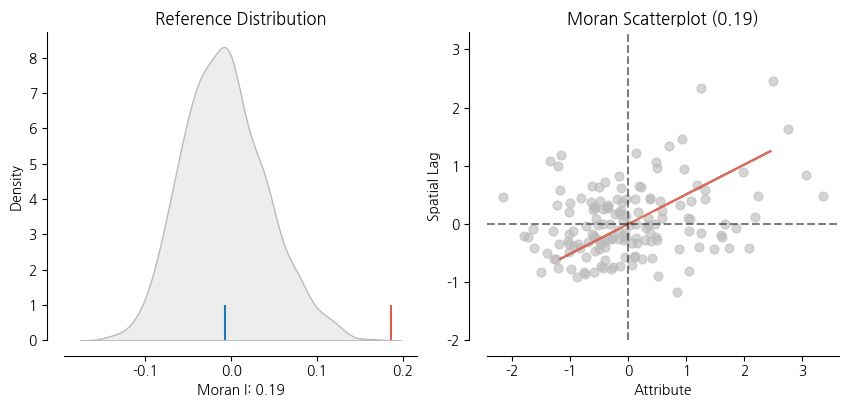

In [69]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.savefig(os.path.join(spatial_path,'moran\'s I(평균폐업기간).jpg'))
plt.show()

In [70]:
moran.p_sim

0.001

- p-value가 0.001이므로 유의수준 5%이내에서 전역적으로 보았을 때 군집이 존재하다고 이야기 할수 있다.

## 2.2 LISA 분석
- 왜 국지적 모델(GWR)을 써야하는가?
- Morans'I를 통해서 공간적 의존성은 확인할 수 있으나 공간적 이질성은 확인할 수가 없다.
- 공간적 의존성 : 공간상의 한 지점에서 측정된 현상이 다른 지점에서의 측정값과 서로 관련이 있을 때 나타난다.
- 공간적 이질성 : 각 지점이나 지역에 내재된 고유성에서 발생하게 되는 자료의 지리적 변이나 통계적 특성의 차이를 말한다.
- LISA 검정을 통해서 공간적 이질성이 존재하는지 확인해본다.
- H0 : 특정지역별로 공간적 군집이 형성되지 않는다.
- 유의 수준 : 0.05

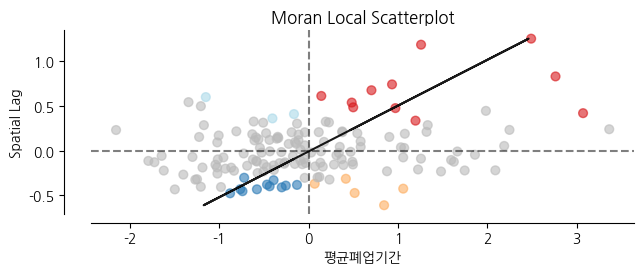

In [71]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisa = Moran_Local(y, w)
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel('평균폐업기간')
ax.set_ylabel('Spatial Lag')
plt.savefig(os.path.join(spatial_path,'Local_Moran\'I(평균폐업기간).jpg'))
plt.show()

In [72]:
sig = lisa.p_sim < 0.05
sig.sum()

30

In [73]:
hotspots = lisa.q==1 * sig
hotspots.sum()

11

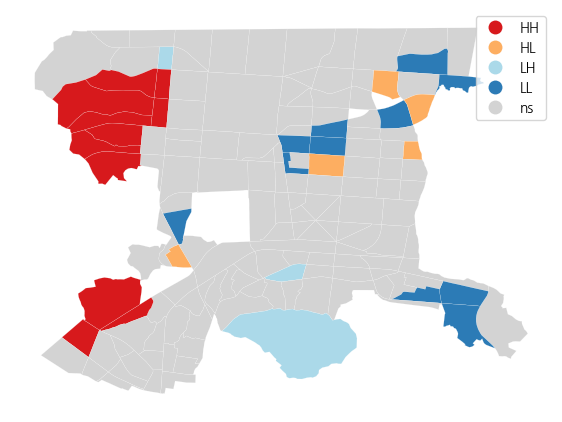

In [74]:
from splot.esda import lisa_cluster

gdf = gpd.GeoDataFrame(gdf)

lisa_cluster(lisa, gdf, p=0.05, figsize = (7,7))
plt.show()

# 3. OLS

In [26]:
import statsmodels.api as sm

X = ind_var
X = sm.add_constant(X)
y = clean_data.loc[:,'평균폐업기간'].values
    
ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     2.236
Date:                Wed, 29 Dec 2021   Prob (F-statistic):            0.00199
Time:                        11:03:54   Log-Likelihood:                -746.03
No. Observations:                 151   AIC:                             1544.
Df Residuals:                     125   BIC:                             1623.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.393e+09   6.73e+09     -0.207      0.836   -1.47e+10    1.19e+10
도로길이고려_전체통합도           -0.0102      0.106     -0.097      0.923      -0.219       0.199
도로길이고려_국부통합도_R3         0.0047      0.009      0.540      0.590      -0.012       0.022
기초구역평균_전체통합도          153.7038    431.058      0.357      0.722    -699.414    1006.822
기초구역평균_국부통합도_R3       -27.8221     63.589     -0.438      0.662    -153.672      98.028
도로율                    -1.0316      0.376     -2.743      0.007      -1.776      -0.287
평균 도로 길이               -0.1662      0.050     -3.302      0.001      -0.266      -0.067
평균최근접역거리                5.1757      8.522      0.607      0.545     -11.690      22.042
평균최근접정류장거리           -144.5456    102.610     -1.409      0.161    -347.623      58.532
공동주택 비율                -0.2016      0.207     -0.975      0.331      -0.611       0.208
근린생활시설 비율              -0.1692      0.203     -0.832      0.407      -0.572       0.233
단독주택 비율                -0.3103      0.232     -1.335      0.184      -0.770       0.150
아파트 가구수                -0.0081      0.004     -1.913      0.058      -0.016       0.000
외식업매출비율              1.393e+09   6.73e+09      0.207      0.836   -1.19e+10    1.47e+10
서비스업매출비율             1.393e+09   6.73e+09      0.207      0.836   -1.19e+10    1.47e+10
소매업매출비율              1.393e+09   6.73e+09      0.207      0.836   -1.19e+10    1.47e+10
외식업종다양성                 5.3155      9.714      0.547      0.585     -13.909      24.540
서비스업종다양성                0.0224     10.374      0.002      0.998     -20.508      20.553
소매업종다양성                -9.5630     11.173     -0.856      0.394     -31.676      12.550
상가밀도                    0.0031      0.004      0.792      0.430      -0.005       0.011
주중 / 주말                85.0097     29.780      2.855      0.005      26.071     143.948
06 to 18 / 18 to 06    -0.2164     15.910     -0.014      0.989     -31.705      31.272
(주거인구+직장인구) / 유동인구     32.9022     17.200      1.913      0.058      -1.138      66.942
주거인구/직장인구               0.0108      0.156      0.069      0.945      -0.298       0.320
10_30 / 40_60         -68.1140     56.561     -1.204      0.231    -180.055      43.827
점포밀도                   -0.0425      0.087     -0.490      0.625      -0.214       0.129
==============================================================================
Omnibus:                        9.930   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.027
Skew:                           0.560   Prob(JB):                      0.00665
Kurtosis:                       3.583   Cond. No.                     2.18e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance ma

# 4. 지리가중회귀분석(MGWR)

## 4.1 독립변수, 종속변수 설정

In [27]:
scaler = MinMaxScaler()
mm_scaled_dX = pd.DataFrame(scaler.fit_transform(ind_var.loc[:,optimal_feature]),columns=optimal_feature)

# 독립변수, 종속변수
s_X = mm_scaled_dX.values
s_y = clean_data['평균폐업기간'].values.reshape((-1,1)) 

# 좌표 데이터 설정
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

## 4.2 MODELING

In [29]:
#Calibrate MGWR model
# 평균영업기간

mgwr_selector = Sel_BW(s_coords, s_y, s_X,multi=True,kernel='exponential',spherical=True)
mgwr_bw = mgwr_selector.search(criterion='AICc',multi_bw_min=[2])
print(mgwr_bw)
mgwr_model = MGWR(s_coords, s_y, s_X, mgwr_selector,kernel='exponential',spherical=True,hat_matrix=True)
mgwr_results = mgwr_model.fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[150. 150. 150. 138. 148. 150. 150.  24. 150. 150. 147.  94. 150. 150.
 150. 150.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 151
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         195075.801
Log-likelihood:                                                    -755.131
AIC:                                                               1542.263
AICc:                                                              1548.864
BIC:                                                             194398.468
R2:                                                                   0.220
Adj. R2:                                                              0.134

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## 4.3 잔차 Moran's I 확인

### 4.3.1 MGWR

In [31]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = mgwr_results.resid_response
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=999)
moran.I

-0.056752155052212525

In [32]:
print('{:.5f}'.format(moran.p_sim))
# 귀무가설을 기각할 수 없으므로 공간적으로 상관성이 없다고 말할 수 있다.

0.15100


### 4.3.2 OLS

In [33]:
import statsmodels.api as sm

X = mm_scaled_dX
X = sm.add_constant(X)
y = clean_data.loc[:,'평균폐업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2.545
Date:                Wed, 29 Dec 2021   Prob (F-statistic):            0.00231
Time:                        11:05:42   Log-Likelihood:                -755.13
No. Observations:                 151   AIC:                             1542.
Df Residuals:                     135   BIC:                             1591.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                148.9697     22.992      6.479      0.000     103.499     194.441
주거인구/직장인구             -2.4361     41.479     -0.059      0.953     -84.468      79.596
아파트 가구수              -57.0800     21.023     -2.715      0.007     -98.658     -15.502
단독주택 비율              -24.1991     21.822     -1.109      0.269     -67.357      18.959
서비스업매출비율             -15.4469     19.321     -0.799      0.425     -53.658      22.764
외식업매출비율               22.9606     15.078      1.523      0.130      -6.860      52.781
근린생활시설 비율            -16.4268     19.625     -0.837      0.404     -55.239      22.385
평균최근접역거리              15.6185     13.372      1.168      0.245     -10.827      42.064
(주거인구+직장인구) / 유동인구    41.3806     20.902      1.980      0.050       0.043      82.719
공동주택 비율              -23.4969     20.375     -1.153      0.251     -63.792      16.798
평균 도로 길이             -48.7779     21.677     -2.250      0.026     -91.649      -5.907
도로길이고려_전체통합도          35.1665     17.136      2.052      0.042       1.277      69.056
평균최근접정류장거리           -42.8641     27.813     -1.541      0.126     -97.870      12.142
점포밀도                 -36.5853     51.472     -0.711      0.478    -138.381      65.211
도로율                  -62.7058     20.887     -3.002      0.003    -104.013     -21.399
상가밀도                   9.6981     48.026      0.202      0.840     -85.283     104.680
==============================================================================
Omnibus:                        8.120   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                7.877
Skew:                           0.506   Prob(JB):                       0.0195
Kurtosis:                       3.477   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = results.resid
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=999)
moran.I

0.04140973296810121

In [35]:
moran.p_sim

0.166

## 4.4 MGWR 회귀계수

In [ ]:
mgwr_coef_df = pd.DataFrame(mgwr_results.params)
mgwr_coef_df.columns = ['intercept']+optimal_feature
mgwr_coef_df['x'] = u
mgwr_coef_df['y'] = v
mgwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
mgwr_coef_df.to_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균영업기간,mm,data_1222).csv',index=False,encoding='euc-kr')

In [36]:
mgwr_coef_df = pd.DataFrame(mgwr_results.params,index=clean_data.BAS_ID)
mgwr_coef_df.columns = ['intercept']+optimal_feature

In [39]:
agg_coef = mgwr_coef_df.describe()

In [40]:
agg_coef_T = agg_coef.loc[['min','max','mean','std'],:].transpose()
agg_coef_T
agg_coef_T.to_csv('../data/전처리 파일/회귀계수/회귀계수 통계량(평균폐업기간).csv',encoding='euc-kr')

### 4.4.1 Column별 회귀계수 분포

In [41]:
coef_ols = pd.DataFrame({'columns':['const']+optimal_feature
                            ,'coef':results.params})

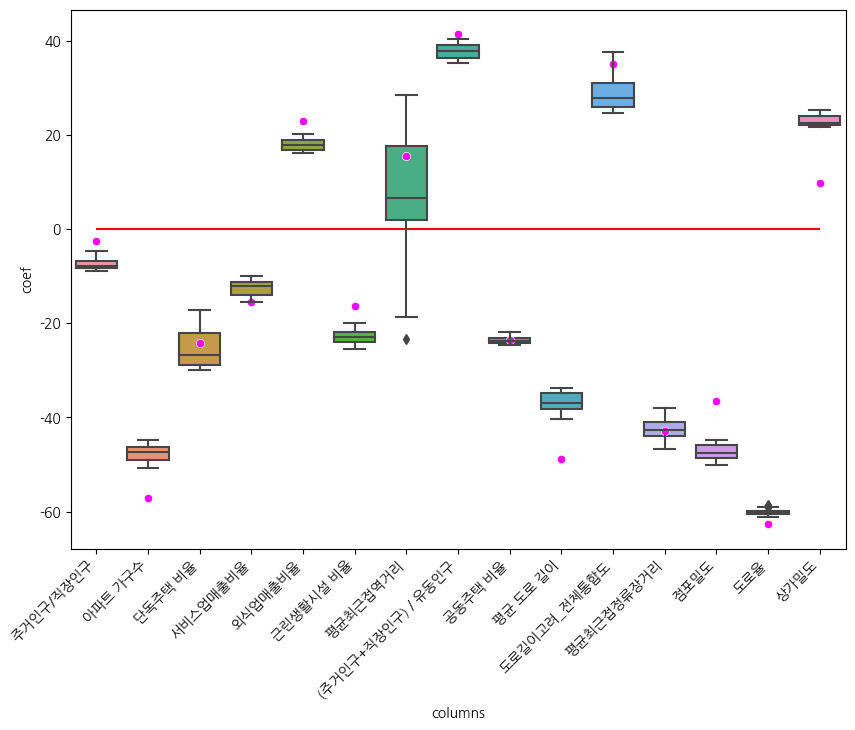

In [42]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

sns.boxplot(data=mgwr_coef_df.iloc[:,1:],ax=ax)
sns.scatterplot(x='columns',y='coef',data=coef_ols.iloc[1:,:],color='magenta',ax=ax)
ax.set_xticklabels(mgwr_coef_df.columns[1:], rotation=45, ha='right')
ax.hlines(y=0,color='red',xmin=0,xmax=14)

plt.savefig('../data/결과 이미지/회귀계수 boxplot(평균폐업기간).jpg')
plt.show()

 ## 4.5 local collinearity

In [43]:
local_con_num = pd.Series(mgwr_results.local_collinearity()[0].flatten())

In [44]:
local_con_num.sort_values(ascending=False)

16     26.856607
17     26.815632
27     26.807733
19     26.791711
18     26.770025
         ...    
150    24.333555
123    24.315110
122    24.271636
97     24.269217
121    24.169170
Length: 151, dtype: float64

## 4.6 Restriction Distance

In [45]:
def local_cdist(coords_i, coords, spherical):
    """
    Compute Haversine (spherical=True) or Euclidean (spherical=False) distance for a local kernel.
    """
    if spherical:
        dLat = np.radians(coords[:, 1] - coords_i[1])
        dLon = np.radians(coords[:, 0] - coords_i[0])
        lat1 = np.radians(coords[:, 1])
        lat2 = np.radians(coords_i[1])
        a = np.sin(
            dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        R = 6371.0
        return R * c
    else:
        return np.sqrt(np.sum((coords_i - coords)**2, axis=1))

In [53]:
bw_list = range(10,151,10)
pos_count = 151
coords = np.array(s_coords)
eps = 1.0000001

df = pd.DataFrame({'BAS_ID':clean_data['BAS_ID']})

for bw in bw_list:
    max_dis_list = []
    for i in range(pos_count): 
        dis_list = local_cdist(coords[i],coords,True)
        max_dis = np.partition(dis_list,int(bw) - 1)[int(bw) - 1] * eps  #partial sort in O(n) Time
        max_dis_list.append(max_dis)
    
    df[str(bw)] = max_dis_list
    
max_dis_list = []
for i in range(pos_count):
    dis_list = local_cdist(coords[i],coords,True)
    max_dis = np.partition(dis_list,int(151) - 1)[int(151) - 1] * eps  #partial sort in O(n) Time
#         print(max_dis)
    max_dis_list.append(max_dis)
    
df['151'] = max_dis_list

df.head()

,BAS_ID,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,151
0,21300,1.378723,2.074619,3.002842,3.282459,3.642628,3.950850,4.153286,4.371838,4.513176,4.714049,4.851600,5.082418,5.279207,5.588497,6.941716,7.322066
1,21301,1.118967,2.071483,2.680156,3.100215,3.454723,3.761402,4.031756,4.236493,4.486328,4.663459,4.867998,5.122608,5.407733,5.738404,6.813341,7.165132
2,21302,1.067706,1.751039,2.306041,2.651497,3.028297,3.401452,3.693161,3.847888,4.150501,4.417687,4.584507,4.921190,5.303693,5.613791,6.455183,6.789521
3,21303,0.863112,1.630758,2.325094,2.702566,3.041361,3.336000,3.577820,3.858758,4.020111,4.218530,4.420522,4.670906,4.981909,5.341734,6.338744,6.693935
4,21304,0.869947,1.452804,1.998713,2.395312,2.752247,3.024644,3.424064,3.531872,3.770207,4.041107,4.213198,4.556331,4.974179,5.288458,6.082202,6.421385


In [54]:
df.describe()

,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,151
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.757660,1.172853,1.542854,1.842262,2.126692,2.382403,2.611156,2.838005,3.069142,3.308786,3.556677,3.830906,4.194812,4.640280,5.476631,5.631133
std,0.218917,0.312568,0.430944,0.510857,0.589420,0.636906,0.657333,0.660823,0.666735,0.683162,0.690700,0.697255,0.713277,0.768418,0.872322,0.901497
min,0.489206,0.789802,1.009479,1.217565,1.419208,1.593138,1.778079,1.918638,2.144224,2.307513,2.522644,2.778845,3.051226,3.325796,3.736440,3.886513
25%,0.602592,0.935138,1.212630,1.465930,1.648180,1.880369,2.070283,2.314441,2.528443,2.760522,2.999221,3.298719,3.605286,3.980420,4.807495,4.948126
50%,0.704997,1.088702,1.412044,1.661344,1.901923,2.139890,2.404141,2.647709,2.877921,3.178918,3.429483,3.687997,4.107574,4.550046,5.407699,5.562298
75%,0.854144,1.369893,1.779656,2.138587,2.494287,2.841433,3.090686,3.334717,3.562609,3.823169,4.117600,4.367813,4.733021,5.183105,6.117607,6.297607
max,1.805900,2.548425,3.002842,3.282459,3.642628,3.950850,4.207514,4.443243,4.691194,4.938259,5.165505,5.456968,5.700715,6.584106,7.406314,7.496667


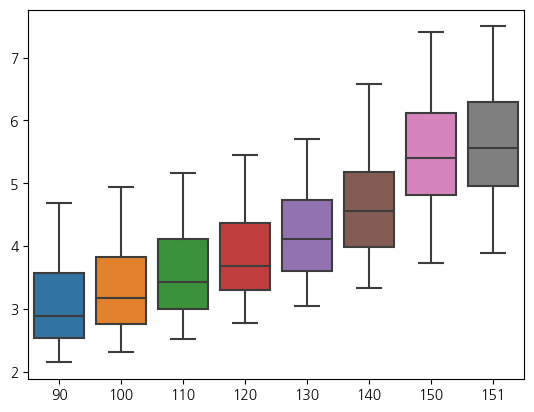

In [55]:
sns.boxplot(data=df.loc[:,'90':])
plt.savefig('../data/결과 이미지/restrict_bw(평균폐업기간).jpg')
plt.show()

In [56]:
dist_Q3 = dict(df.describe().loc['75%'])
max_dist_dict = dist_Q3
max_dist_dict

{'10': 0.8541444032261423,
 '20': 1.3698925051311814,
 '30': 1.77965642112302,
 '40': 2.1385871666274285,
 '50': 2.4942873470533455,
 '60': 2.8414330234756604,
 '70': 3.0906856310080038,
 '80': 3.334716933542952,
 '90': 3.5626090240921107,
 '100': 3.8231692398700137,
 '110': 4.117599599351064,
 '120': 4.3678127142873535,
 '130': 4.733021384268406,
 '140': 5.183105170860003,
 '150': 6.117607347467548,
 '151': 6.297607046776433}

In [60]:
temp_bw = []

for bw in range(10,152):
    start_bw = int(bw / 10)*10
    start_dist = max_dist_dict[str(int(start_bw))]
    
    if start_bw != 150:
        temp_bw.append(start_dist+(max_dist_dict[str(int(start_bw)+10)]-start_dist)/10*(bw-start_bw))
    else:
        temp_bw.append(start_dist+(max_dist_dict[str(int(start_bw)+1)]-start_dist)/1*(bw-start_bw))
    
distance_by_bw = pd.DataFrame({'bw':range(10,152),'distance':temp_bw})

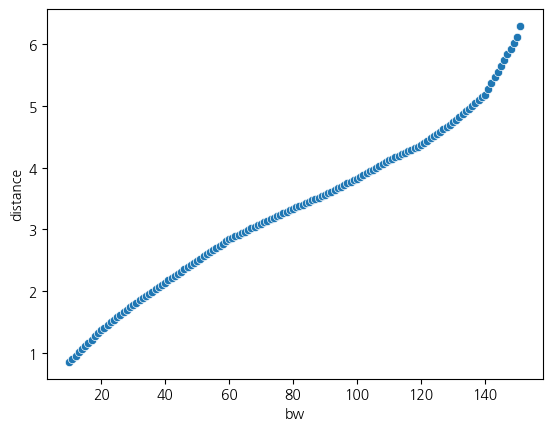

In [61]:
sns.scatterplot(x=distance_by_bw['bw'],y=distance_by_bw['distance'])
plt.savefig('../data/결과 이미지/restrict_bw_smooth_graph(평균폐업기간).jpg')
plt.show()